In [1]:
import pandas as pd
import numpy  as np
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import pygrib
from colorspacious import cspace_converter

In [2]:
"""
1-1 Read Grib from file
"""
def openGribFile(gfile, glist=False,  verbose=False):
    grib = pygrib.open(gfile)
    if verbose:
        print("Lecture du fichier grib %s."%(gfile))
        gr=grib[1]
        print("Domaine : %fx%f:%fx%f"%(gr['longitudeOfFirstGridPointInDegrees']-360., 
                                       gr['latitudeOfFirstGridPointInDegrees'], 
                                       gr['longitudeOfLastGridPointInDegrees']-360., 
                                       gr['latitudeOfLastGridPointInDegrees']))
        print("Ni : %i  -  Nj : %i"%(gr['Ni'], gr['Nj']))
        print("Di : %i  -  Dj : %i"%(gr['Di'], gr['Dj']))
        Ngrib=0
        for g in grib:
            Ngrib+=1
        print("Paramètres : %i"%(Ngrib))

    # Listing of grib
    if glist:
        for g in grib:
            print(g)
    #
    return grib

    

In [3]:
"""
1-2 Read fields from Grib
"""
def readFieldsFromGribByNum(gfile, gids=None, verbose=False ):
    if len(gids)<1:
        return [None]
    lats=None
    lons=None
    fields=[]
    grib = openGribFile(gfile, glist=False,  verbose=verbose)
    if verbose:
        print("Lecture des champs :")
    for gid in gids:
        try:
            gr = grib[gid]
            values = gr.values
            (lats, lons) = gr.latlons()
            fields.append([gr['name'],gr['shortName'], gr['units'], gr['typeOfLevel'], gr['level'],lons-360, lats, values])
            if verbose:
                print("\tParam: %s - Values : %f to %f in (%s)"%(gr['shortName'],np.amin(values), np.amax(values), gr['units']))
                
        except:
            fields.append(None)
    return fields

In [4]:
"""
2- Read Particular points (Station's Network) from csv file
"""
def readStationPoints(pfile=None, verbose=False):
    if pfile is None:
        return None
    if verbose:
        print("Lecture du fichier des points (particuliers)")
    st = pd.read_csv(pfile)
    points = geopandas.GeoDataFrame(
            st, geometry=geopandas.points_from_xy(st.LON, st.LAT), crs='epsg:4326')
    return points

In [5]:
"""
3- Read Elevation/Mask data from text file

"""  
def readFieldsFromText(tfile, nlat=691, nlon=661,verbose=False):
    if verbose:
        print("Lecture des indices Terre/Mer")
    Lon, Lat, Mask, Elev = np.loadtxt(tfile, unpack=True)
    df  = pd.DataFrame({'X':Lon, 'Y':Lat, 'Z':Elev}).sort_index(ascending=False, axis=1)
    #
    # 
    altX=df.X.array.reshape(nlon, nlat)
    altY=df.Y.array.reshape(nlon, nlat)
    altZ=df.Z.array.reshape(nlon, nlat)
    return altX, altY, altZ

In [6]:
"""
3- Read fields from text file

"""  
def readMultiFieldsFromText(tfile, nlat=691, nlon=661, names=None, verbose=False):
    if verbose:
        print("Lecture des indices Terre/Mer")
    Fields = np.genfromtxt(tfile, names=names, unpack=True, missing_values="NA") 
      
    dpar = {}
    for i in range(len(names)):
        if names[i]=='Lon':
            dpar['X'] = Fields[i]
        elif names[i]=='Lat':
            dpar['Y'] = Fields[i]
        elif names[i]!='Dat' and names[i]!='Ech':
            dpar[names[i]] = Fields[i]
        
    df  = pd.DataFrame(dpar)
    #
    # 
    X=df.X.array.reshape(nlon, nlat)
    Y=df.Y.array.reshape(nlon, nlat)
    names=names[4:]
    Z={}
    for p in names:
        Z[p] = np.array(df[p].array.reshape(nlon, nlat))
    return X, Y, Z
    

In [7]:
"""
3- Read Fields from csv file
+> Les paramètres extraits dans l’ordre des colonnes :
      c1.  -- Date du jour
      c2.  -- Echeance de prévision
      c3.  -- Longitude du point de grille
      c4.  -- Latitude  du point de grille
      c5.  -- 'CLSTEMPERATURE' : température à 2m. Unité: K.
      c6.  -- 'CLSMINI.TEMPERAT' : température minimale à 2m. Unité: K.
      c7.  -- 'CLSMAXI.TEMPERAT' : température maximale à 2m. Unité: K.
      c8.  -- 'CLSHUMI.RELATIVE' : humidité relative minimale à 2m. Unité: sans. Entre 0 et 1.
      c9.  -- 'CLSVENT.ZONAL' : vent zonal à 10m. Unité: m/s.
      c10. -- 'CLSVENT.MERIDIEN' : vent méridien à 10m. Unité: m/s.
      c11. -- 'CLSU.RAF.MOD.XFU' : rafales de vent zonal à 10m. Unité: m/s.
      c12. -- 'CLSV.RAF.MOD.XFU' : rafales de vent méridien à 10m. Unité: m/s.
      c13. -- 'MSL_NHPRESSURE' : Pression réduite au niveau de la mer. Unité : Pa.
      c14. -- 'SURFPRESSION' : Pression  en surface. Unité : Pa.
      c15. -- 'SURFACCPLUIE' :  Cumul des précipitations depuis le début du run. Unité : mm.
      c16. -- 'H00002CLOUD_WATE' : Contenu en Eau Liquide à 2m. Unité : kg/kg.
      c17. -- 'H00005CLOUD_WATE' : Contenu en Eau Liquide à 5m. Unité : kg/kg.
      c18. -- 'SURFNEBUL.BASSE' :

"""  
def readFieldsFromcsv(file, verbose=False):
    if verbose:
        print("Lecture des champs dans le fichier %s."%(file))
    df = pd.read_csv(file, sep=';', header='infer')

    params = np.array(df.columns)
    lastElementIndex = len(params)-1
    params=params[4:lastElementIndex]
    
    X=df.Lon.array.reshape(661, 691)
    Y=df.Lat.array.reshape(661, 691)
    Z={}
    if verbose:
        print("Les champs contenus dans %s :\n%r"%(file, params))

    for p in params:
        Z[p] = np.array(df[p].array.reshape(661, 691))
        
    return X,Y,Z, params

In [8]:
"""
4- Read shapeFile and create "Maroc" shape by union of region shapes
"""
def readShapefileRegions(verbose=False):
    if verbose:
        print("Lecture du shapefile Maroc/Régions.")
    shapefile = 'regions/regions.shp'
    gdf = geopandas.read_file(shapefile)

    """
    Union des polygones pour avoir le Maroc comme un seul polygone pour pouvoir tracer le contour.
    """
    if verbose:
        print("Création de l'enveloppe du Maroc par union des shapes des régions.")
    polys=[]
    for g in gdf.geometry:
        polys.append(g)
    union = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(unary_union(polys)), crs="EPSG:4326")
    return gdf, union

In [9]:
"""
5- Select region by number from geopandas of regions
"""
def getRegionByNum(gdf, numRegion):
    """
    Region list by numRegion :
    ------------------------------------
    0            RABAT-SALÉ-ZEMMOUR-ZAER          
    1               RÉGION DE L'ORIENTAL           
    2              OUED EDDAHAB-LAGOUIRA           
    3                       FÈS-BOULMANE       
    4                  CHAOUIA OUARDIGHA        
    5         MARRAKECH-TENSIFT-EL HAOUZ 
    6                       TADLA-AZILAL   
    7           GHARB-CHRARDA-BÉNI HSSEN    
    8   LAÂYOUNE-BOUJDOUR-SAKIA EL HAMRA   
    9            TAZA-AL HOCEIMA-TOUNATE    
    10                  GRAND CASABLANCA   
    11                  MEKNÈS-TAFILALET 
    12                  SOUSS-MASSA-DRÂA  
    13                    TANGER-TÉTOUAN   
    14                 GUELMIM-ES-SEMARA  
    15                     DOUKKALA ABDA   
    """
    reg = gdf.iloc[numRegion]
    region = geopandas.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[reg.geometry])
    return reg['POLY_NM_TR'], region

In [10]:
"""
6-1 Create polygon from coordinates (lat, lon) and transform it to GeoDataFrame object
"""
def createPolyFromCoordinates(lat, lon):
    poly_geom = Polygon(zip(lon, lat))
    poly = geopandas.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[poly_geom])
    return poly

In [69]:
"""
6-2 Create zone of plot
"""
def createZoneToPlot(gmask=None, base=None, points=None, byPoly=True):
    if base is None:
        return None, None
    if gmask is not None:
        if byPoly:
            dzone = base.clip(gmask)
        else:
            dzone = gmask
        #
        print(type(points), type(dzone.geometry[0]))
        zpoints = geopandas.clip(points, dzone)
    else :
        dzone   = base
        zpoints = points  
    #
    return dzone, zpoints

In [59]:
"""
7- Tools
"""
def arrayRelache(X, Y, U, V, step):
    (Ni, Nj)=X.shape
    return X[0:Ni:step, 0:Nj:step], Y[0:Ni:step, 0:Nj:step], U[0:Ni:step, 0:Nj:step], V[0:Ni:step, 0:Nj:step]


In [60]:
def wind2knots(u, v, unit="m s**-1"):
    if unit == "m s**-1":
        return ("knots", u*1.94, v*1.94)
    else:
        return (unit, u, v)

In [73]:
"""
8- Plot params on selected Zone
"""
def plotUsingRectangularMask(fig, ax, Xa, Ya, Z, params=None, dzone=None, withSeaMask=True, points=None, 
                ptype=None, lStep=None, cmaps=None, withContourLabels=False, cbtitle=None,
                scatterSize=10, marker='s', markColor='k', markerSize=20,
                title='', titleFontSize=25, labelSize=10, kwargs=None, verbose=True):
    #
    if dzone is None:
        print("Le domaine de plot n'est pas défini.")
        return 
    #
    [minx, miny, maxx, maxy]=dzone.total_bounds
    if withSeaMask:
        margex = abs(maxx - minx)/20.
        margey = abs(maxy - miny)/20.
        minx -= margex
        miny -= margey
        maxx += margex
        maxy += margey
        # Create rectangular mask by difference between polygon and dzone
        lat_point_list = [miny, maxy, maxy, miny, miny]
        lon_point_list = [minx, minx, maxx, maxx, minx]
        poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
        mask = poly.difference(dzone)
        #
    plt.xlim([minx, maxx])
    plt.ylim([miny, maxy])

    withCbar=False
    X=Xa[0]
    Y=Ya[0]
    for i in range(len(Z)):
        if Xa[i] is not None:
            X=Xa[i]
            Y=Ya[i]
        if params is not None and verbose:
            print("Paramètre : ",  params[i])
        step=lStep[i]
        if cmaps is not None and cmaps[i] is not None:
            cmap=cmaps[i]
        else:
            cmap='gist_gray_r'
        #
        if ptype[i] == "contourf":                
            if step > 1:
                levels = np.arange(int(np.amin(Z[i]))-step, int(np.amax(Z[i]))+step, step)
            else:
                levels = np.arange(np.amin(Z[i])-step, np.amax(Z[i])+step, step)
            cs = ax.contourf(X, Y, Z[i], levels=levels, cmap=cmap, zorder=3)
            withCbar=True
        elif ptype[i] == "contour":
            if step > 1:
                levels = np.arange(int(np.amin(Z[i])), int(np.amax(Z[i]))+step, step)
            else:
                levels = np.arange(int(np.amin(Z[i]))-step, int(np.amax(Z[i]))+step, step)
            cc=ax.contour(X, Y, Z[i],   colors=cmap, levels=levels, zorder=4)
            if withContourLabels:
                ax.clabel(cc, inline=True, fontsize=10, zorder=4)
        elif ptype[i] == "barbs":
            U=Z[i][0]
            V=Z[i][1]
            Xi, Yi, Ui, Vi = arrayRelache(X, Y, U, V, step)
            q = ax.barbs(Xi, Yi, Ui, Vi, zorder=5, color=cmap)
        elif ptype[i] == "quiver":
            U=Z[i][0]
            V=Z[i][1]
            Xi, Yi, Ui, Vi = arrayRelache(X, Y, U, V, step)
            q = ax.quiver(Xi, Yi, Ui, Vi, zorder=5, color=cmap, **kwargs )
        
  
    if withSeaMask:
        mask.plot(ax=ax, color='w', zorder=5)
        poly.boundary.plot(ax=ax, color='k', zorder=5)
    #
    if points is not None:
        points.plot(ax=ax, color=markColor, markersize=markerSize, marker=marker, zorder=3 );
    #


    dzone.boundary.plot(ax=ax, color='k', zorder=4, linewidth=3 )
    #
    ax.set_title(title, fontsize=titleFontSize)
    ax.set_xlabel('Longitudes (°)', fontsize=labelSize)
    ax.set_ylabel('Latitudes (°)', fontsize=labelSize)
    ax.tick_params(axis='both', which='major', labelsize=labelSize)
    if withCbar:
        cbar = fig.colorbar(cs, ax=ax, fraction=0.05, pad=0.01)
        cbar.ax.tick_params(labelsize=labelSize)
        if cbtitle is not None:
            cbar.set_label(cbtitle, fontsize=labelSize)
    

In [74]:
"""
9- Guide d'utilisation
"""
def printHelp():
    print(
    """
    Examples : 
        Pour utiliser la fonction plotUsingRectangularMask, on commence par préparer les données :
        1- lecture des points particuliers à ploter sur la carte: 
            # Ces points sont lues dans un fichier csv 
            # contenant les colonnes suivantes : LON, LAT, NOM

        2- Sélection de la zone d'affichage:
            #     La zone d'affichage est sélectionnée par la variable "case" :
            #      case=1 # tout le maroc
            #      case=2 # un polygone définis par une liste de points
            #      case=3 # une région donnée par son numéro "reg"
            #         Liste des régions (extrait du shipfile) :
            #         ------------------------------------
            #         0            RABAT-SALÉ-ZEMMOUR-ZAER          
            #         1               RÉGION DE L'ORIENTAL           
            #         2              OUED EDDAHAB-LAGOUIRA           
            #         3                       FÈS-BOULMANE       
            #         4                  CHAOUIA OUARDIGHA        
            #         5         MARRAKECH-TENSIFT-EL HAOUZ 
            #         6                       TADLA-AZILAL   
            #         7           GHARB-CHRARDA-BÉNI HSSEN    
            #         8   LAÂYOUNE-BOUJDOUR-SAKIA EL HAMRA   
            #         9            TAZA-AL HOCEIMA-TOUNATE    
            #         10                  GRAND CASABLANCA   
            #         11                  MEKNÈS-TAFILALET 
            #         12                  SOUSS-MASSA-DRÂA  
            #         13                    TANGER-TÉTOUAN   
            #         14                 GUELMIM-ES-SEMARA  
            #         15                     DOUKKALA ABDA  

        3- Lecture des champs et préparation des informations d'entrée :
            # Les champs peuvent être lus à partir de :
            #    - fichier texte en utilisant la fonction (readMultiFieldsFromText)
            #    - fichier csv   en utilisant la fonction (readFieldsFromcsv)
            #    - fichier grib  en utilisant la fonction (readFieldsFromGribByNum)
            # On adapte les champs (cas par cas) au plot (par exemple, on convert la température en °C, le vent en
            # noeuds 'Knots', ...).
            #
            # Les entrées de la fonction plotUsingRectangularMask qui seront préparées à cette phase sont :
            #     X : tableau des tableaux 2D des coordonnées lon
            #     Y : tableau des tableaux 2D des coordonnées lat
            #     Z : tableau des tableaux 2D des valeurs des paramètres
            #     P : tableau des noms de paramètres
            #     steps  : tableau des pas de tracé des champs
            #     cmaps  : tableau des couleurs de tracé
            #     ptypes : tableau des type de tracé (contour, contourf, barbs, [arrow])
            # 
            # N.B: On ne peut tracer qu'une seule variable de type contourf. Si l'on en passe plusieurs à 
            # la fonction, uniquement la dernière qui apparaitra sur la carte.
            #
            # L'ordre des variables à tracer n'est pas important. 
            # La fonction trace tout d'abord la variable en contourf, puis les variables en contour 
            # et enfin les variables en barbules en utilisant des 'zorder' différents pour chacun des types de
            # plot.
        4-  Appeler la fonction plotUsingRectangularMask:
            # Pour le choix des couleurs, soit on ultilise les cmap prédéfinis de matplotlib ou ou on en 
            # construit un.
            # Pour avoir une idée des couleurs prédéfinis, executer la fonction showPredefinedCmap().
            #
            # Les cmap prédéfinis (par catégorie) sont : 
            # 'Perceptually Uniform Sequential':
            #             ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
            # 'Sequential':
            #             ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            #              'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #              'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
            # 'Sequential (2)':
            #             ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
            #              'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
            #              'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
            # 'Diverging':
            #             ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
            #              'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
            # 'Cyclic': 
            #             ['twilight', 'twilight_shifted', 'hsv']
            # 'Qualitative':
            #             ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
            #              'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
            #              'tab20c']
            # 'Miscellaneous':
            #             ['flag', 'prism', 'ocean', 'gist_earth', 'terrain',
            #              'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
            #              'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
            #              'turbo', 'nipy_spectral', 'gist_ncar']
            #
            # Pour travailler avec le cmap inversé (couleur min correspondant à valeur max ainsi de suite), on
            # ajoute au nom le suffixe '_r', par exemple pour 'gray' le cmap inverse est 'gray_r'
            #
    """)

In [75]:
"""
10- Guide de choix des couleurs
"""
def showPredefinedCmap():
    cmaps = {}
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))


    def plot_color_gradients(category, cmap_list):
        # Create figure and adjust figure height to number of colormaps
        nrows = len(cmap_list)
        figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
        fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
        fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                            left=0.2, right=0.99)
        axs[0].set_title(f'{category} colormaps', fontsize=14)

        for ax, name in zip(axs, cmap_list):
            ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
            ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                    transform=ax.transAxes)

        # Turn off *all* ticks & spines, not just the ones with colormaps.
        for ax in axs:
            ax.set_axis_off()

        # Save colormap list for later.
        cmaps[category] = cmap_list
        
    plot_color_gradients('Perceptually Uniform Sequential',
                         ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])
    plot_color_gradients('Sequential',
                         ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                          'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])
    plot_color_gradients('Sequential (2)',
                         ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                          'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                          'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'])
    plot_color_gradients('Diverging',
                         ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                          'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'])
    plot_color_gradients('Cyclic', ['twilight', 'twilight_shifted', 'hsv'])
    plot_color_gradients('Qualitative',
                         ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                          'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                          'tab20c'])
    plot_color_gradients('Miscellaneous',
                         ['flag', 'prism', 'ocean', 'gist_earth', 'terrain',
                          'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
                          'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
                          'turbo', 'nipy_spectral', 'gist_ncar'])

    plt.show()

In [76]:
"""
11- Example1 : Plot from Grib and Text files
"""
def example1(kwargs=None):
    # 
    # 1- Lecture du fichier des points particuliers (lat lon nom)
    #
    pfile='DGM-Network.csv'
    spoints      = readStationPoints(pfile=pfile, verbose=True)

    #
    # 2- Sélection de la zone d'affichage
    #
    case=1 # tout le maroc
    #case=2 # un rectangle (-7.,30.)x(0.,36.)
    #case=3 # une région donnée par son numéro
    #reg=1     
    #
    geodf, maroc = readShapefileRegions(verbose=True)
    #
    if case==1:
        dzone=maroc
        points=spoints
        zoneName="Maroc"
        wstep = 30
    elif case==2:
        lat_point_list = [30., 36., 36., 30., 30.] # Pour avoir un polygone (ligne fermée) :
        lon_point_list = [-7., -7.,  0.,  0., -7.] # le point initial et le point final ont les mêmes coordonnées
        zoneName="Zone entre (-12., 30.) et (0., 36.)"
        poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
        dzone, points = createZoneToPlot(gmask=poly, base=maroc, points=spoints, byPoly=True)
        wstep=25
    elif case==3:
        zoneName, region  = getRegionByNum(geodf, reg)
        dzone, points = createZoneToPlot(gmask=region, base=maroc, points=spoints, byPoly=False)
        wstep=10
    #
    # 3- Lecture des champs et préparation des informations d'entrée
    #    
    #  Cas de lecture à partir d'un fichier GRIB
    gfile = "GRIBPFALADMAROC+0000_00"
    # 
    # liste des paramètres par leurs numéros dans le fichier grib
    # ex --> 22: t2m, 23: rh2m, 24: u2m, 25: v2m
    params=[22,23,24,25]  
    fields = readFieldsFromGribByNum(gfile, gids=params, verbose=True )
    # initialisation des tableaux entrées:
    Z=[]
    X=[]
    Y=[]
    P=[]
    steps=[]
    cmaps=[]
    ptypes=[]
    
    # Cas de prétraitement du champ humidité relative (s'intéresser aux valeurs supérieures à minRh)
    minRh=90
    [name, sname, unit, tlevel, level, Xe, Ye, rh] = fields[1]
    rhshape = rh.shape
    rh1 = rh.flatten()
    rh1 = np.array([ max(minRh, r) for r in rh1])
    rh  = rh1.reshape(rhshape)
    Z.append(rh) 
    X.append(Xe)
    Y.append(Ye)
    P.append('rh')
    steps.append(5)
    cmaps.append('m')
    ptypes.append('contour')
    title=sname
    # Cas de traitement des champs vents (U et V) (conversion to knots)
    [name, sname, unit, tlevel, level, Xe, Ye, u2] = fields[2]
    [name, sname, unit, tlevel, level, Xe, Ye, v2] = fields[3]
    unit, u, v = wind2knots(u2, v2, unit)
    Z.append([u,v]) 
    X.append(Xe)
    Y.append(Ye)
    P.append('wind')
    steps.append(wstep)
    cmaps.append('b')
    ptypes.append('barbs')

    title+="/wind"
    #
    # 3- Lecture du fichier Texte : (Lat Lon Mask Elev )
    #
    tfile='INDTERREMER-ALT-AROME.dat'
    Xe, Ye, E = readFieldsFromText(tfile, verbose=True)
    Z.append(E) 
    X.append(Xe)
    Y.append(Ye)
    P.append('Elev')
    steps.append(100)
    cmaps.append('gist_gray_r')
    ptypes.append('contourf')

    title+="/Elevation"
    #
    # Tracé des champs
    #
    title  = "%s\n%s at %s (%s)"%(zoneName, title, level, tlevel) # titre du plot
    cbtitle="Elevation (m)"                                       # titre de la barre des couleurs
    #
    plotMe=True
    if plotMe:
        fig, ax = plt.subplots(1, 1, figsize=(20,16))
        plotUsingRectangularMask(fig, ax, X, Y, Z, params=P, title=title, 
                                 withSeaMask=True, 
                                 withContourLabels=True,
                                 cbtitle=cbtitle,
                                 lStep=steps, 
                                 cmaps=cmaps,
                                 ptype=ptypes,
                                 dzone=dzone, 
                                 points=points,  
                                 marker="s", markerSize=50,
                                 labelSize=18,
                                 kwargs=kwargs)

Lecture du fichier des points (particuliers)
Lecture du shapefile Maroc/Régions.
Création de l'enveloppe du Maroc par union des shapes des régions.
Lecture du fichier grib GRIBPFALADMAROC+0000_00.
Domaine : -17.500000x37.000000:-0.250000x20.500000
Ni : 691  -  Nj : 661
Di : 25000  -  Dj : 25000
Paramètres : 1242
Lecture des champs :
	Param: 2t - Values : 261.639863 to 306.626100 in (K)
	Param: 2r - Values : 0.003212 to 100.003212 in (%)
	Param: 10u - Values : -22.605673 to 14.954567 in (m s**-1)
	Param: 10v - Values : -16.650720 to 14.446693 in (m s**-1)
Lecture des indices Terre/Mer
Paramètre :  rh
Paramètre :  wind
Paramètre :  Elev


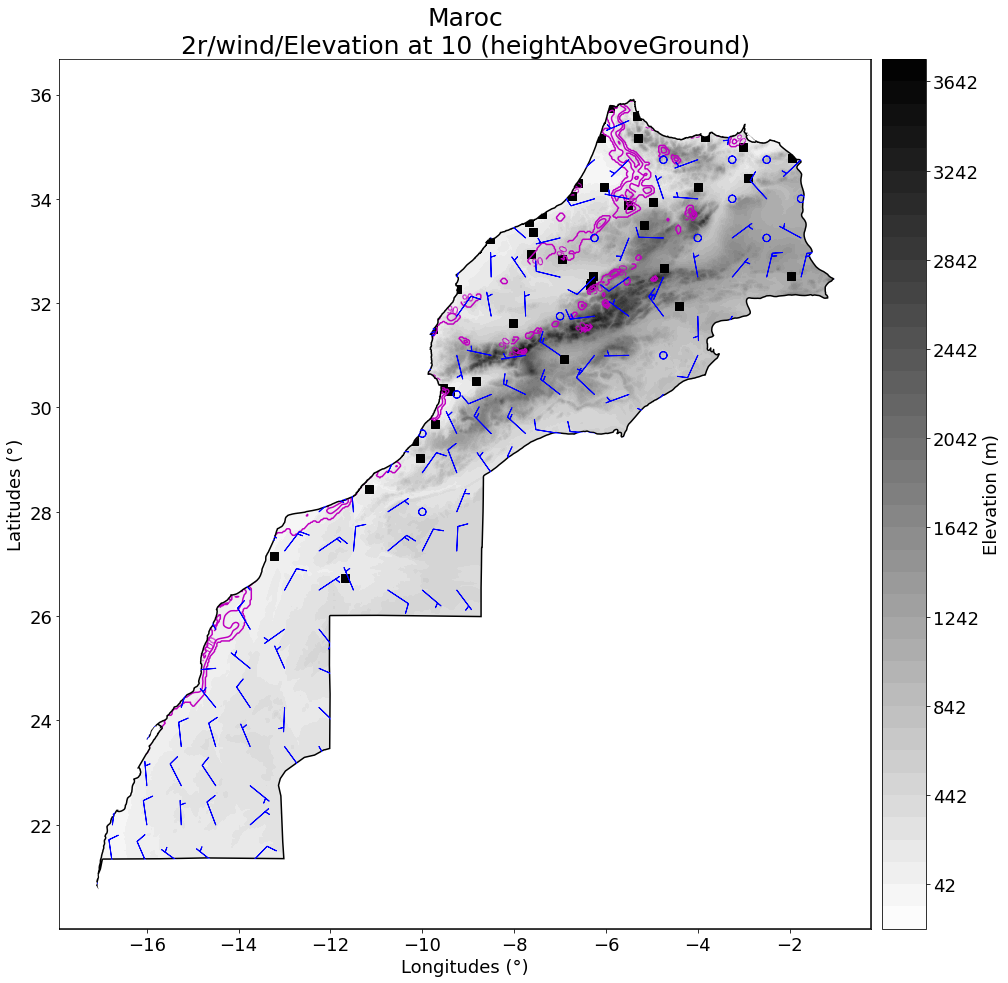

In [77]:
example1()

In [78]:
"""
12- Example 2 : Plot from csv file 
"""

def example2(kwargs=None):
    # 
    # 1- Lecture du fichier des points particuliers (lat lon nom)
    #
    pfile='DGM-Network.csv'
    spoints      = readStationPoints(pfile=pfile, verbose=True)

    #
    # 2- Sélection de la zone d'affichage
    #
    #case=1 # tout le maroc
    #case=2 # un rectangle (-7.,30.)x(0.,36.)
    case=3 # une région donnée par son numéro
    reg=1     
    #
    geodf, maroc = readShapefileRegions(verbose=True)

    #
    if case==1:
        dzone=maroc
        points=spoints
        zoneName="Maroc"
        wstep = 30
    elif case==2:
        lat_point_list = [30., 36., 36., 30., 30.] # Pour avoir un polygone (ligne fermée) :
        lon_point_list = [-7., -7.,  0.,  0., -7.] # le point initial et le point final ont les mêmes coordonnées
        zoneName="Zone entre (-12., 30.) et (0., 36.)"
        poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
        dzone, points = createZoneToPlot(gmask=poly, base=maroc, points=spoints, byPoly=True)
        wstep=25
    elif case==3:
        zoneName, region  = getRegionByNum(geodf, reg)
        dzone, points = createZoneToPlot(gmask=region, base=maroc, points=spoints, byPoly=False)
        wstep=10
    #
    # 3- Lecture des champs et préparation des informations d'entrée
    #    
    #  Cas de lecture à partir d'un fichier csv
    file="Multi-Fields-4-Python.csv"
    # 
    # initialisation des tableaux entrées:
    Z=[]
    X=[]
    Y=[]
    P=[]
    steps=[]
    cmaps=[]
    ptypes=[]

    #

    Xe, Ye, fields, par = readFieldsFromcsv(file, verbose=False)
    """
    ['CLSTEMPERATURE' 'CLSMINI.TEMPERAT' 'CLSMAXI.TEMPERAT' 'CLSHUMI.RELATIVE'
     'CLSVENT.ZONAL' 'CLSVENT.MERIDIEN' 'CLSU.RAF.MOD.XFU' 'CLSV.RAF.MOD.XFU'
     'MSL_NHPRESSURE' 'SURFPRESSION' 'SURFACCPLUIE' 'H00002CLOUD_WATE'
     'H00005CLOUD_WATE']
    """
    # 1- CLSTEMPERATURE :
    clst= fields['CLSTEMPERATURE']
    Z.append(clst-273.15) 
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSTEMPERATURE')
    steps.append(2)
    cmaps.append('gist_ncar_r')
    ptypes.append('contourf')
    title='CLSTEMPERATURE'
    cbtitle="CLSTEMPERATURE(°C)"

    # 1- CLSHUMI.RELATIVE :
    minRh=90 # Permet de limiter l'affichage des contours pour les humidités relatives inférieures à minRh
    rh= fields['CLSHUMI.RELATIVE']*100.
    rhshape = rh.shape
    rh1 = rh.flatten()
    rh1 = np.array([ max(minRh, r) for r in rh1])
    rh  = rh1.reshape(rhshape)
    Z.append(rh)
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSHUMI.RELATIVE')
    steps.append(5)
    cmaps.append('m')
    ptypes.append('contour')
    title+='/CLSHUMI.RELATIVE'

    # Vents ('CLSVENT.ZONAL', 'CLSVENT.MERIDIEN') (conversion to knots)
    v2 = fields['CLSVENT.ZONAL']
    u2 = fields['CLSVENT.MERIDIEN']
    unit = 'm s**-1'
    unit, u, v = wind2knots(u2, v2, unit)
    Z.append([u,v]) 
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSVENT')
    steps.append(wstep)
    cmaps.append('r')
    ptypes.append('quiver')
    title+="/CLSVENT"
    #
    #
    # Tracé des champs
    #
    title  = "%s\n%s "%(zoneName, title) # titre du plot
    #
    plotMe=True
    if plotMe:
        fig, ax = plt.subplots(1, 1, figsize=(20,16))

        plotUsingRectangularMask(fig, ax, X, Y, Z, params=P, title=title, 
                                 withSeaMask=True, 
                                 withContourLabels=True,
                                 cbtitle=cbtitle,
                                 lStep=steps, 
                                 cmaps=cmaps,
                                 ptype=ptypes,
                                 dzone=dzone, 
                                 points=points,  
                                 marker="s", markerSize=50,
                                 labelSize=18,
                                 kwargs=kwargs)

Lecture du fichier des points (particuliers)
Lecture du shapefile Maroc/Régions.
Création de l'enveloppe du Maroc par union des shapes des régions.
<class 'geopandas.geodataframe.GeoDataFrame'> <class 'shapely.geometry.polygon.Polygon'>
Paramètre :  CLSTEMPERATURE
Paramètre :  CLSHUMI.RELATIVE
Paramètre :  CLSVENT


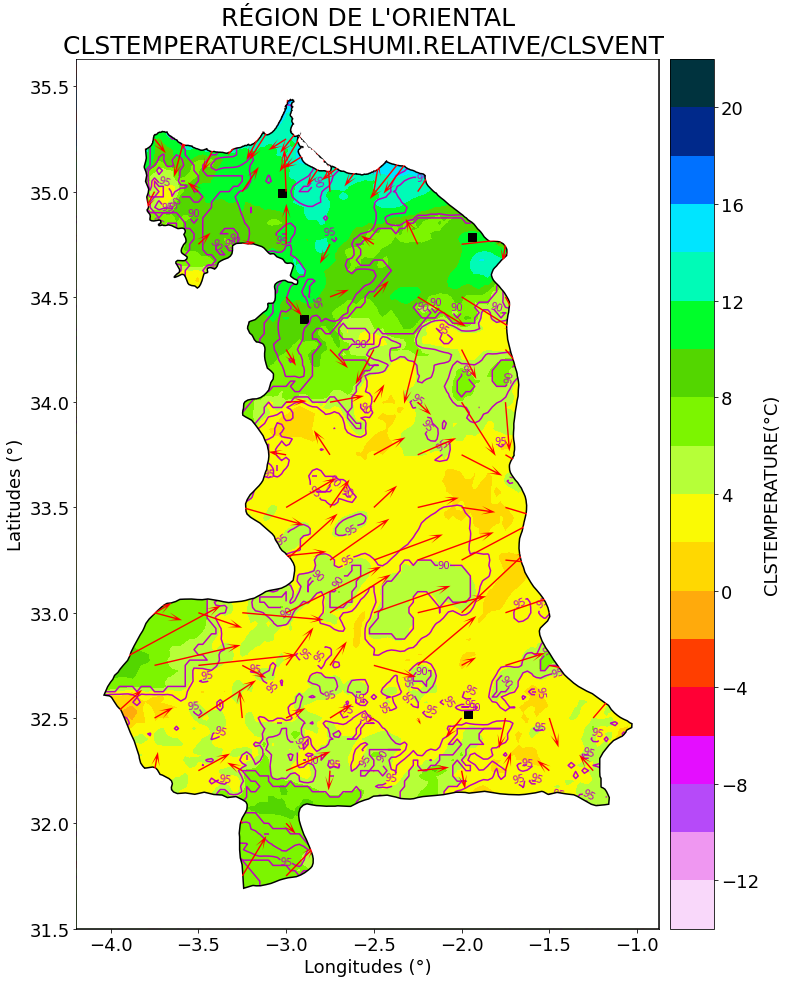

In [79]:
kwargs =dict(headwidth=6, headlength=10,  angles='xy', scale_units='xy', scale=25)
example2(kwargs=kwargs)

In [80]:
"""
13- Example 3 : Plot from text file 
"""
def example3(kwargs=None):
    # 
    # 1- Lecture du fichier des points particuliers (lat lon nom)
    #
    pfile='DGM-Network.csv'
    spoints      = readStationPoints(pfile=pfile, verbose=True)

    #
    # 2- Sélection de la zone d'affichage
    #
    #case=1 # tout le maroc
    #case=2 # un rectangle (-7.,30.)x(0.,36.)
    case=3 # une région donnée par son numéro
    reg=3     
    #
    geodf, maroc = readShapefileRegions(verbose=True)
    #
    if case==1:
        dzone=maroc
        points=spoints
        zoneName="Maroc"
        wstep = 30
    elif case==2:
        lat_point_list = [30., 36., 36., 30., 30.] # Pour avoir un polygone (ligne fermée) :
        lon_point_list = [-7., -7.,  0.,  0., -7.] # le point initial et le point final ont les mêmes coordonnées
        zoneName="Zone entre (-12., 30.) et (0., 36.)"
        poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
        dzone, points = createZoneToPlot(gmask=poly, base=maroc, points=spoints, byPoly=True)
        wstep=25
    elif case==3:
        zoneName, region  = getRegionByNum(geodf, reg)
        dzone, points = createZoneToPlot(gmask=region, base=maroc, points=spoints, byPoly=False)
        wstep=10
    #
    # 3- Lecture des champs et préparation des informations d'entrée
    #    
    #  Cas de lecture à partir d'un fichier Text
    tfile="Multi-Fields-4-Python.txt"
    names = ['Dat','Ech','Lon','Lat','CLSTEMPERATURE','CLSMINI.TEMPERAT','CLSMAXI.TEMPERAT','CLSHUMI.RELATIVE',
             'CLSVENT.ZONAL','CLSVENT.MERIDIEN','CLSU.RAF.MOD.XFU','CLSV.RAF.MOD.XFU','MSL_NHPRESSURE',
             'SURFPRESSION','SURFACCPLUIE','H00002CLOUD_WATE','H00005CLOUD_WATE','SURFNEBUL.BASSE']


    Xe, Ye, fields= readMultiFieldsFromText(tfile, names=names, verbose=True)
    # 
    # initialisation des tableaux entrées:
    Z=[]
    X=[]
    Y=[]
    P=[]
    steps=[]
    cmaps=[]
    ptypes=[]


    # 1- CLSTEMPERATURE :
    clst= fields['CLSTEMPERATURE']
    Z.append(clst-273.15) 
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSTEMPERATURE')
    steps.append(2)
    cmaps.append('gist_ncar_r')
    ptypes.append('contourf')
    title='CLSTEMPERATURE'
    cbtitle="CLSTEMPERATURE(°C)"

    # 1- CLSHUMI.RELATIVE :
    minRh=90 # Permet de limiter l'affichage des contours pour les humidités relatives inférieures à minRh
    rh= fields['CLSHUMI.RELATIVE']*100.
    rhshape = rh.shape
    rh1 = rh.flatten()
    rh1 = np.array([ max(minRh, r) for r in rh1])
    rh  = rh1.reshape(rhshape)
    Z.append(rh)
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSHUMI.RELATIVE')
    steps.append(5)
    cmaps.append('m')
    ptypes.append('contour')
    title+='/CLSHUMI.RELATIVE'

    # Vents ('CLSVENT.ZONAL', 'CLSVENT.MERIDIEN') (conversion to knots)
    v2 = fields['CLSVENT.ZONAL']
    u2 = fields['CLSVENT.MERIDIEN']
    unit = 'm s**-1'
    unit, u, v = wind2knots(u2, v2, unit)
    Z.append([u,v]) 
    X.append(Xe)
    Y.append(Ye)
    P.append('CLSVENT')
    steps.append(wstep)
    cmaps.append('r')
    ptypes.append('barbs')
    title+="/CLSVENT"
    #
    #
    # Tracé des champs
    #
    title  = "%s\n%s "%(zoneName, title) # titre du plot
    #
    plotMe=True
    if plotMe:
        fig, ax = plt.subplots(1, 1, figsize=(20,16))
        plotUsingRectangularMask(fig, ax, X, Y, Z, params=P, title=title, 
                                 withSeaMask=True, 
                                 withContourLabels=True,
                                 cbtitle=cbtitle,
                                 lStep=steps, 
                                 cmaps=cmaps,
                                 ptype=ptypes,
                                 dzone=dzone, 
                                 points=points,  
                                 marker="s", markerSize=50,
                                 labelSize=18,
                                 kwargs=kwargs)

Lecture du fichier des points (particuliers)
Lecture du shapefile Maroc/Régions.
Création de l'enveloppe du Maroc par union des shapes des régions.
<class 'geopandas.geodataframe.GeoDataFrame'> <class 'shapely.geometry.polygon.Polygon'>
Lecture des indices Terre/Mer
Paramètre :  CLSTEMPERATURE
Paramètre :  CLSHUMI.RELATIVE
Paramètre :  CLSVENT


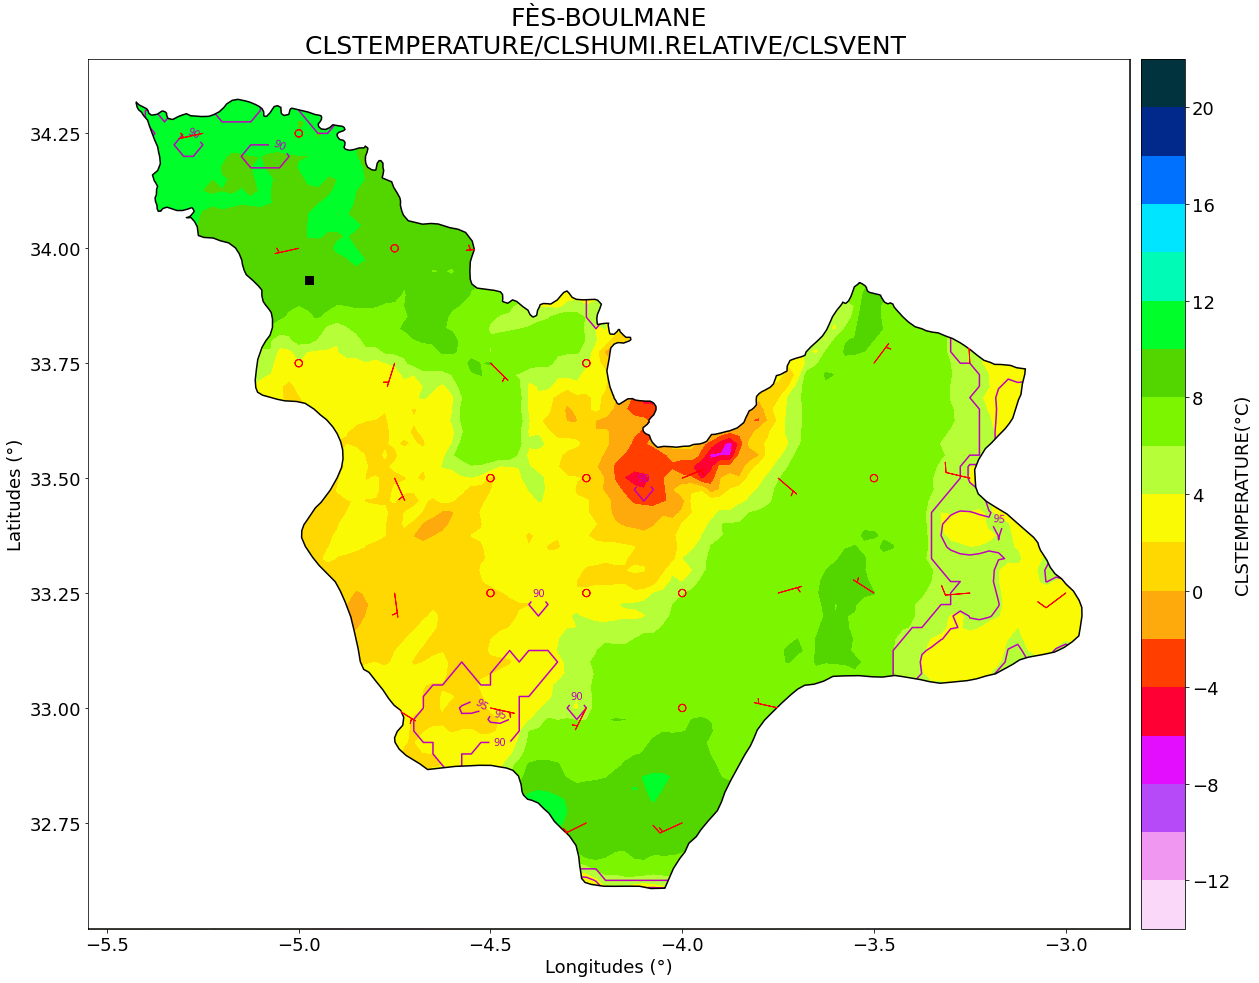

In [82]:
example3()